In [1]:
### Imports and environment
# Imports
import os
import io
from dotenv import load_dotenv
# import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.colormaps as mcolormaps
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaIoBaseDownload
import requests

### Set static paths
svc_hiit_dash_workout = '/Users/curtismcginity/stanford/research/proj/HIITvsMICT/secrets/gcp/hiit-vs-mict-50dbc00f450b.json'

### Set gdrive folders
fid_root = '0AB6End4Uf7P-Uk9PVA'
fid_workout = '1a9Bmg89_9m9BaYLsLw52PS_m07FQ7CtZ'
fid_sl_fitbit = '11rL8hgBPvlGUQAyq_f0HYjsrbCRNtizQ'

### Load env variables
load_dotenv()

True

In [5]:
def setup_drive():
    SCOPES = ['https://www.googleapis.com/auth/drive.readonly']

    creds = Credentials.from_service_account_file(svc_hiit_dash_workout, scopes=SCOPES)
    service = build('drive', 'v3', credentials=creds)
    return service

def load_data_from_drive(_drive_service, file_id):
    request = _drive_service.files().get_media(fileId=file_id)
    io_buffer = io.BytesIO()
    downloader = MediaIoBaseDownload(io_buffer, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
    io_buffer.seek(0)
    df = pd.read_csv(io_buffer, parse_dates=['_realtime','_time'])
    # df = df[df['value'] >= 0.8 * df['target_hr_45']]
    return df


def preload_data_from_drive(parent_id):
    drive_service = setup_drive()
    preloaded_data = {}
    
    # Get list of files in the specified folder
    response = drive_service.files().list(corpora='drive', 
                                          driveId=fid_root,
                                          q=f"'{parent_id}' in parents",
                                          includeItemsFromAllDrives=True, 
                                          supportsAllDrives=True).execute()
    # Iterate over each file and load its data
    for file in response.get('files', []):
        if file.get('name').startswith("workout"):
            continue
        file_id = file['id']
        df = load_data_from_drive(drive_service, file_id)
        preloaded_data[file_id] = df
    
    return preloaded_data

def preload_data_from_drive2(parent_id):
    drive_service = setup_drive()
    preloaded_data = {}
    
    # Get list of files in the specified folder
    response = drive_service.files().list(corpora='drive', 
                                          driveId=fid_root,
                                          q=f"'{parent_id}' in parents",
                                          includeItemsFromAllDrives=True, 
                                          supportsAllDrives=True).execute()
    # Iterate over each file and load its data
    for file in response.get('files', []):
        if file.get('name').startswith("q"):
            continue
        file_id = file['id']
        df = load_data_from_drive(drive_service, file_id)
        preloaded_data[file_id] = df
    
    return preloaded_data

def get_file_ids_from_dir(parent_id):
    drive_service = setup_drive()
    results = drive_service.files().list(
        corpora='drive',
        driveId=fid_root,
        q=f"'{parent_id}' in parents",
        includeItemsFromAllDrives=True,
        supportsAllDrives=True
    ).execute()
    files = results.get('files', [])
    if not files:
        raise Exception(f"Folder {parent_id} has no files!")
    # id_name = [{x['name'] : x['id']} for x in files]
    id_name = {}
    for x in files:
        id_name[x['name']] = x['id']
    return id_name

def read_redcap_report(api_url, api_key, report_id):
    """
    Reads a specific report from REDCap into a pandas DataFrame.

    :param api_url: URL to the REDCap API endpoint.
    :param api_key: API key for authentication.
    :param report_id: ID of the report to be fetched.
    :return: DataFrame containing the report data or None if an error occurs.
    """

    # Define the payload for the REDCap API request
    data = {
        'token': api_key,
        'content': 'report',
        'format': 'csv',
        'report_id': report_id,
        'rawOrLabel': 'raw',
        'rawOrLabelHeaders': 'raw',
        'exportCheckboxLabel': 'false',
        'returnFormat': 'csv'
    }

    # Make the POST request to the REDCap API
    response = requests.post(api_url, data=data)

    # Check if the request was successful
    if response.status_code != 200:
        print(f"Error fetching data from REDCap: {response.text}")
        return None

    # Convert the CSV response to a pandas DataFrame
    try:
        df = pd.read_csv(io.StringIO(response.text))
        return df
    except pd.errors.ParserError:
        print("Error parsing REDCap response as CSV")
        return None

In [6]:
sl_fids = get_file_ids_from_dir(fid_sl_fitbit)
sldfs = preload_data_from_drive2(fid_sl_fitbit)


In [7]:
sldfs[sl_fids['007_qtz1b18472445718468562_sl_WearableFitbit_Fitbit.csv']]

,device,start_date,end_date,start_time,end_time,value,tag,type,_time,myphd_id,...,target_hr_45,target_hr_55,target_hr_70,target_hr_90,ppt_id,_realtime,dow,dow_abbr,moy,moy_abbr
0,Fitbit,2028-04-28,NaN,22:13:30,NaN,3,NaN,wake,2028-04-28 22:13:30,qtz1b18472445718468562,...,134.85,144.15,158.1,176.7,7,2023-04-16 22:13:30,6,Sun,4,Apr
1,Fitbit,2028-04-28,NaN,22:14:00,NaN,75,NaN,light,2028-04-28 22:14:00,qtz1b18472445718468562,...,134.85,144.15,158.1,176.7,7,2023-04-16 22:14:00,6,Sun,4,Apr
2,Fitbit,2028-04-28,NaN,22:26:30,NaN,183,NaN,deep,2028-04-28 22:26:30,qtz1b18472445718468562,...,134.85,144.15,158.1,176.7,7,2023-04-16 22:26:30,6,Sun,4,Apr
3,Fitbit,2028-04-28,NaN,22:57:00,NaN,36,NaN,light,2028-04-28 22:57:00,qtz1b18472445718468562,...,134.85,144.15,158.1,176.7,7,2023-04-16 22:57:00,6,Sun,4,Apr
4,Fitbit,2028-04-28,NaN,23:03:00,NaN,177,NaN,rem,2028-04-28 23:03:00,qtz1b18472445718468562,...,134.85,144.15,158.1,176.7,7,2023-04-16 23:03:00,6,Sun,4,Apr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,Fitbit,2028-08-08,NaN,05:22:00,NaN,132,NaN,light,2028-08-08 05:22:00,qtz1b18472445718468562,...,134.85,144.15,158.1,176.7,7,2023-07-27 05:22:00,3,Thu,7,Jul
1784,Fitbit,2028-08-08,NaN,05:44:00,NaN,42,NaN,wake,2028-08-08 05:44:00,qtz1b18472445718468562,...,134.85,144.15,158.1,176.7,7,2023-07-27 05:44:00,3,Thu,7,Jul
1785,Fitbit,2028-08-08,NaN,05:51:00,NaN,9,NaN,light,2028-08-08 05:51:00,qtz1b18472445718468562,...,134.85,144.15,158.1,176.7,7,2023-07-27 05:51:00,3,Thu,7,Jul
1786,Fitbit,2028-08-08,NaN,05:52:30,NaN,102,NaN,rem,2028-08-08 05:52:30,qtz1b18472445718468562,...,134.85,144.15,158.1,176.7,7,2023-07-27 05:52:30,3,Thu,7,Jul


In [14]:
# Authenticate with Google Drive using service account credentials
drive_service = setup_drive()

In [15]:
# Load all workouts for each PPT
workouts_dfs = preload_data_from_drive(fid_workout)

In [146]:
# Load metadata from REDCap report
dfppt = read_redcap_report(os.getenv('api_url'), os.getenv('api_key_curtis'), os.getenv('ppt_meta_master_id'))
# dfppt.head(20)

In [147]:
# Get file name to file id mapping
fname_fid_dict = get_file_ids_from_dir(fid_workout)

In [197]:
def preprocess(df):
    # Ensure datetime format
    df['_realtime'] = pd.to_datetime(df['_realtime'])

    # Ensure ID formatting
    df['wk_id'] = df['wk_id'].apply(lambda x: f'{x:02}')

    # Focus on polar data
    df = df.loc[df['device'] == "Polar"]
    

    # Compute workout start time
    df['_wotime_base'] = df.groupby(['wk_id', 'wo_id'])['_realtime'].transform('min')

    # Calculate a new field _wotime as difference in a resolution (e.g., minutes) from _wotime_base
    df['_wotime'] = (df.loc[:,'_realtime'] - df.loc[:,'_wotime_base']).dt.total_seconds() / 60  # Here, we'll show time in minutes

    # Give a time 

    return df

def plot_workouts(df):
    # ppt = df.loc[0,'ppt_id']
    ppt = df['ppt_id'].apply(lambda x: f'{x:03}')
    ppt = ppt.iloc[0]
    workouts = df.groupby(['wk_id', 'wo_id'])

    # Setup the color map
    n_colors = workouts.ngroups
    cmap = plt.get_cmap('viridis', n_colors) 

    plt.figure(figsize=(10, 6))

    for i, ((wk_id, wo_id), wo) in enumerate(workouts):
        plt.plot(wo['_wotime'], wo['value'], label=f'Week {wk_id}, Workout {wo_id}', color=cmap(i), alpha=0.8)
    
    plt.xlabel('Workout Duration (Minutes)')
    plt.ylabel('HR')
    plt.title(f'{ppt}: Workout Performance Over Time')
    plt.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.) 
    # plt.legend() 
    plt.tight_layout()
    plt.show()

def plot_workouts_2(df):
    
    # Determine unique combinations of wk_id and wo_id
    workout_groups = df.groupby(['wk_id', 'wo_id'])
    
    # Setup the color map
    n_colors = workout_groups.ngroups
    cmap = plt.get_cmap('viridis', n_colors) 
    
    plt.figure(figsize=(10, 6))
    
    # Plot each group
    for i, ((wk_id, wo_id), group) in enumerate(workout_groups):
        # Convert '_wotime' to a proper format for plotting (e.g., hours or minutes)
        wotime_hours = group['_wotime'].dt.total_seconds() / 3600.0
        plt.plot(wotime_hours, group['value'], label=f'Week {wk_id}, Workout {wo_id}',
                 color=cmap(i), alpha=0.8)
    
    plt.xlabel('Time since workout start (hours)')
    plt.ylabel('Value')
    plt.title('Workout Time Series')
    plt.legend(fontsize='small', loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_workouts_corrected(df):
    # Assuming 'df' is your DataFrame and it already includes the '_wotime' column correctly calculated

    # Convert '_wotime' to timedelta if it's not already
    if not pd.api.types.is_timedelta64_dtype(df['_wotime']):
        df['_wotime'] = pd.to_timedelta(df['_wotime'])
    
    # Prepare the colormap
    unique_workouts = df[['wk_id', 'wo_id']].drop_duplicates().shape[0]
    cmap = plt.get_cmap('viridis', unique_workouts)  # Corrected colormap access

    # Group by 'wk_id' and 'wo_id'
    workout_groups = df.groupby(['wk_id', 'wo_id'])

    # Plot settings
    plt.figure(figsize=(12, 8))

    for i, ((wk_id, wo_id), group) in enumerate(workout_groups):
        # Ensure '_wotime' is treated as timedelta for plotting
        wotime_hours = group['_wotime'].dt.total_seconds() / 3600.0
        plt.plot(wotime_hours, group['value'], label=f'Week {wk_id}, Workout {wo_id}',
                 color=cmap(i), alpha=0.8)

    plt.xlabel('Time since workout start (hours)')
    plt.ylabel('Value')
    plt.title('Workout Values Over Time')
    plt.legend(fontsize='small', loc='upper left')
    plt.show()

def plot_data_aggregated(df):
    # First, ensure '_wotime' is in the correct timedelta format if it represents elapsed time
    if not pd.api.types.is_timedelta64_dtype(df['_wotime']):
        df['_wotime'] = pd.to_timedelta(df['_wotime'])
    
    # Convert '_wotime' to minutes for plotting
    df['_wotime_minutes'] = df['_wotime'].dt.total_seconds() / 60.0

    # Aggregate the data
    aggregated_df = (
        df.groupby(['wk_id', 'wo_id'], as_index=False)
        .agg(value_med=('value', 'median'), _wotime_median=('_wotime_minutes', 'median'))
    )

    plt.figure(figsize=(10, 6))

    # Plot each group based on the aggregated data
    for _, row in aggregated_df.iterrows():
        # Plotting the median value against the median '_wotime' might not make sense unless '_wotime' is categorical or pre-binned
        plt.plot(row['_wotime_median'], row['value_med'], label=f'Week {row["wk_id"]}, Workout {row["wo_id"]}', alpha=0.8)

    plt.xlabel('Median Minutes from Workout Start')
    plt.ylabel('Median Value')
    plt.title('Workout Performance Across Time (Median Aggregated)')
    plt.legend(fontsize='small', loc='upper left')
    plt.show()

def plot_data_aggregated2(df):
    # Assuming '_wotime' is already in a suitable numeric format representing minutes or similar from workout start
    # If not, convert '_wotime' to a numeric format that represents the elapsed time in minutes or a suitable time unit

    # Aggregate the data to find the median 'value' for each 'wk_id', 'wo_id', and '_wotime'
    # Note: This approach assumes '_wotime' can be used directly for aggregation. If '_wotime' needs binning, additional steps are required
    aggregated_df = (
        df.groupby(['wk_id', 'wo_id', '_wotime'], as_index=False)
        .agg(value_med=('value', 'median'))
    )

    # Prepare the colormap
    unique_workouts = df[['wk_id', 'wo_id']].drop_duplicates().shape[0]
    cmap = plt.get_cmap('viridis', unique_workouts)  # Corrected colormap access

    # Plotting
    plt.figure(figsize=(10, 6))

    # Since we might lose the continuity in '_wotime' by taking the median, we consider each unique group for plotting
    agg_groups = aggregated_df.groupby(['wk_id', 'wo_id'])
    for i,((wk_id, wo_id), group) in enumerate(agg_groups):
        plt.plot(group['_wotime'], group['value_med'], label=f'Week {wk_id}, Workout {wo_id}', color=cmap(i), alpha=0.8)

    plt.xlabel('Minutes from Workout Start')
    plt.ylabel('Median Value')
    plt.title('Workout Performance Across Time (Median Aggregated)')
    plt.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)    
    plt.tight_layout()
    plt.show()

In [196]:
dftest = workouts_dfs[fname_fid_dict['018_qtz1b19261322566215748_workout_allevents.csv']]
dftest.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122809 entries, 2023-06-14 18:55:08 to 2023-09-03 14:58:20
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   value            122809 non-null  float64       
 1   _time            122809 non-null  datetime64[ns]
 2   ppt_id           122809 non-null  int64         
 3   wk_id            122809 non-null  object        
 4   wo_id            122809 non-null  int64         
 5   datatype         122809 non-null  object        
 6   sourcetype       122809 non-null  object        
 7   device           122809 non-null  object        
 8   myphd_id         122809 non-null  object        
 9   _wotime_base     122809 non-null  datetime64[ns]
 10  _wotime          122809 non-null  float64       
 11  _wotime_minutes  122809 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(5)
memory usage: 12.2+ MB


/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/2359944355.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime_base'] = df.groupby(['wk_id', 'wo_id'])['_realtime'].transform('min')
/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/2359944355.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime'] = (df.loc[:,'_realtime'] - df.loc[:,'_wotime_base']).dt.total_seconds() / 60  # Here, we'll show time in minutes


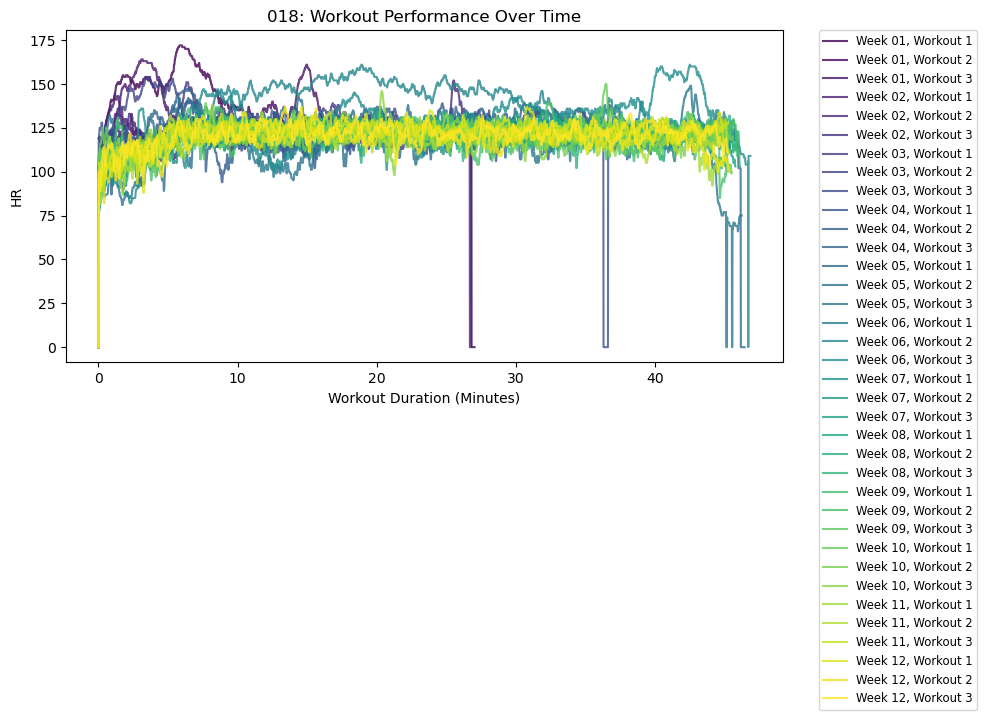

In [167]:
dftest_wotime = preprocess(dftest)
plot_workouts(dftest_wotime)

In [ ]:
plot_workouts2(dftest_wotime)

In [ ]:
dfthing = (dftest
    .groupby(['wk_id', 'wo_id'])
    .agg(value_med=('value','median'))
    .reset_index()
    )
dfthing

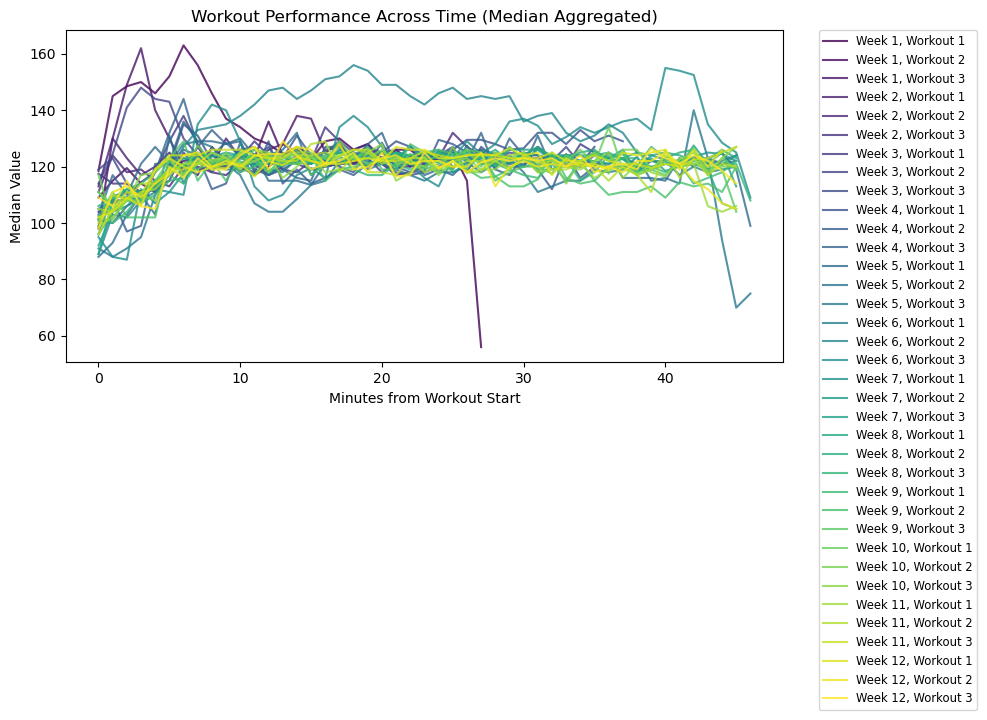

In [74]:
plot_data_aggregated2(dftest)

In [ ]:
for i, (fid, df) in enumerate(workouts_dfs.items()):
    dfpptwos = preprocess(df)
    plot_workouts(dfpptwos)

rows: 3


/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/3587822971.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime_base'] = df.groupby(['wk_id', 'wo_id'])['_realtime'].transform('min')
/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/3587822971.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime'] = (df.loc[:,'_realtime'] - df.loc[:,'_wotime_base']).dt.total_seconds() / 60  # Here, we'll show time in minutes
/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000g

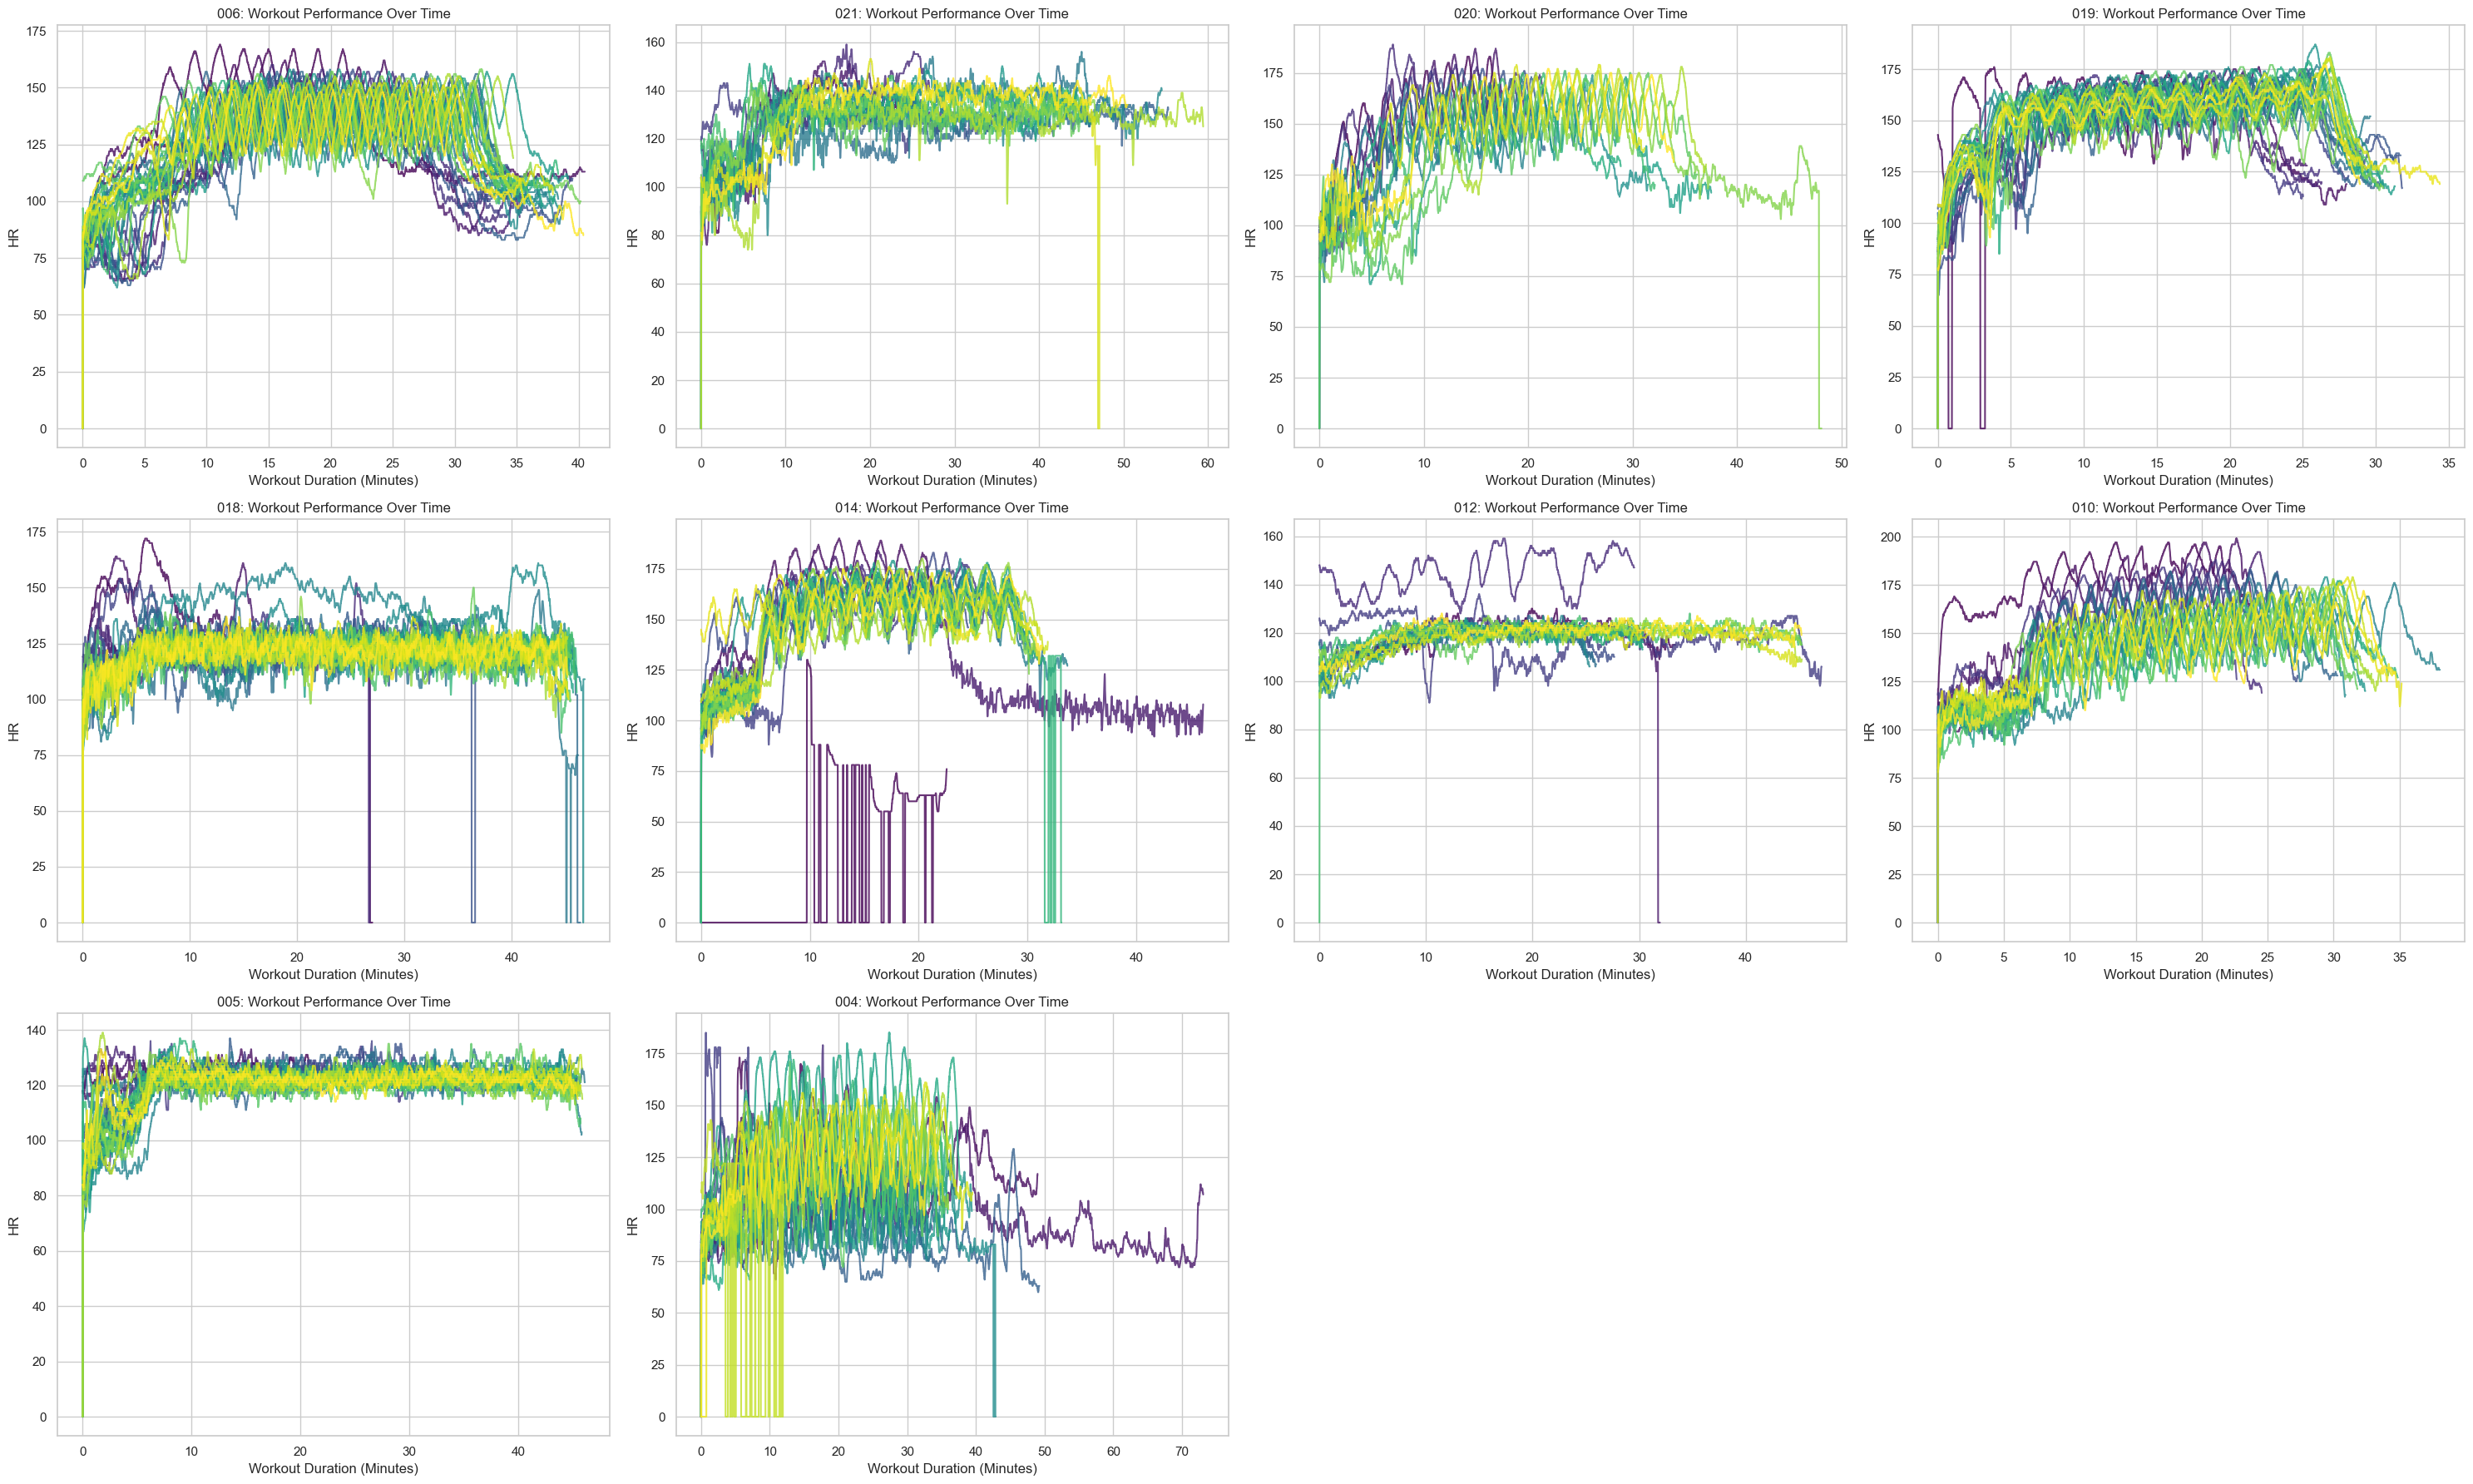

In [187]:
def plot_workouts_grid(df, ax):
    # Assuming ppt_id is a column in df
    ppt = df['ppt_id'].apply(lambda x: f'{x:03}')
    ppt = ppt.iloc[0]
    workouts = df.groupby(['wk_id', 'wo_id'])

    # Setup the color map
    n_colors = workouts.ngroups
    cmap = plt.get_cmap('viridis', n_colors) 

    for i, ((wk_id, wo_id), wo) in enumerate(workouts):
        ax.plot(wo['_wotime'], wo['value'], label=f'Week {wk_id}, Workout {wo_id}', color=cmap(i), alpha=0.8)
    
    ax.set_xlabel('Workout Duration (Minutes)')
    ax.set_ylabel('HR')
    ax.set_title(f'{ppt}: Workout Performance Over Time')
    # ax.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    ax.figure.tight_layout()

# Build plot grid
total_plots = len(workouts_dfs)
columns = 4
rows = (total_plots + 3) // columns  # Calculate rows needed, rounding up
print(f'rows: {rows}')
fig, axs = plt.subplots(rows, columns, figsize=(30, 6*rows))  # Adjust figsize as needed
fig.tight_layout(pad=3.0)  # Add space between plots

# Flatten the axs array if necessary
axs_flat = axs.flatten()

for i, (fid, df) in enumerate(workouts_dfs.items()):
    dfpptwos = preprocess(df)
    ax = axs_flat[i]
    plot_workouts_grid(dfpptwos, ax)  # Pass the specific Axes object to plot_workouts

# If the number of plots is odd, hide the last ax
if total_plots % columns:
    axs_flat[-1].axis('off')  # Hide the last subplot if unused
    axs_flat[-2].axis('off')  # Hide the last 2 subplot if unused

plt.show()

In [168]:
import seaborn as sns

def plot_workouts2(df):
    # Convert ppt_id to string with leading zeros and grab the first one for the title
    ppt = df['ppt_id'].apply(lambda x: f'{x:03}').iloc[0]

    # Creating a new 'label' column for the legend
    df['label'] = df.apply(lambda x: f'Week {x["wk_id"]}, Workout {x["wo_id"]}', axis=1)

    # Set the Seaborn theme for better aesthetics
    sns.set_theme(style="whitegrid")

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotting using Seaborn lineplot for each workout over time
    # Seaborn handles grouping and coloring automatically
    sns.lineplot(data=df, x='_wotime', y='value', hue='label', palette='viridis', ax=ax, alpha=0.8)

    # Enhancing the plot
    ax.set_xlabel('Workout Duration (Minutes)')
    ax.set_ylabel('HR')
    ax.set_title(f'{ppt}: Workout Performance Over Time')

    # Adjusting the legend
    ax.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.05, 1), title='Workout')

    fig.tight_layout()

    # Display the figure without using plt.show() to be compatible with Jupyter notebooks and scripts
    plt.show()

/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/2626569463.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df.apply(lambda x: f'Week {x["wk_id"]}, Workout {x["wo_id"]}', axis=1)


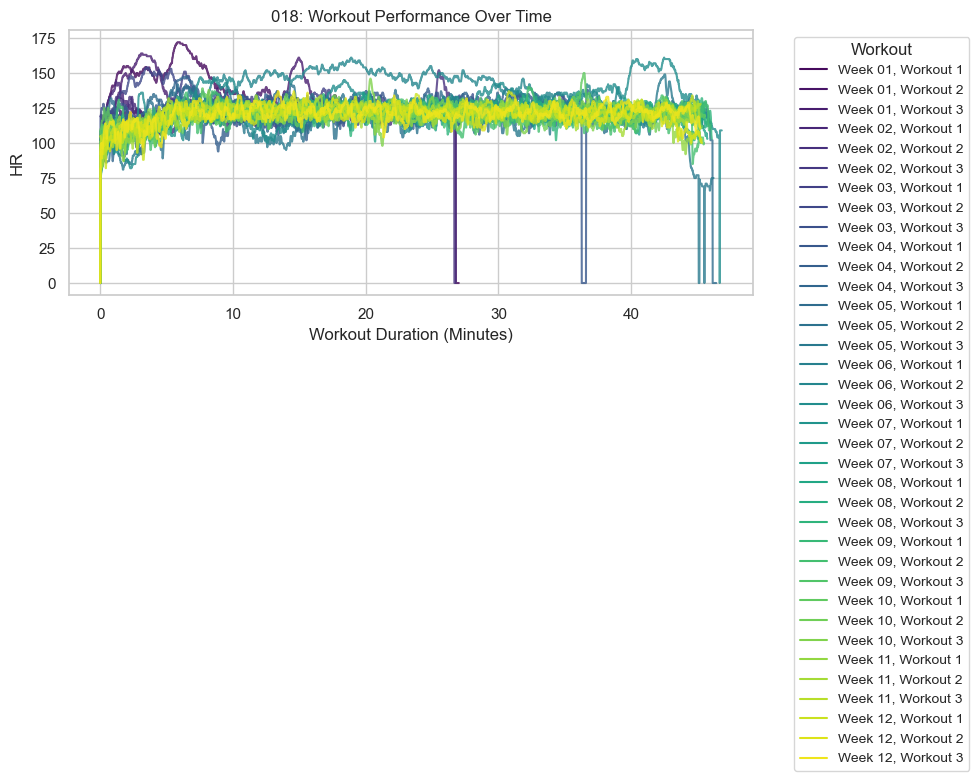

In [170]:
plot_workouts2(dftest_wotime)

## Comparison: Polar H10 vs. Fitbit Versa 4

In [345]:
def preprocess_5s(df):
    df.reset_index(inplace=True)
    # Ensure datetime format
    df['_realtime'] = pd.to_datetime(df['_realtime'])

    # Ensure ID formatting
    df['wk_id'] = df['wk_id'].apply(lambda x: f'{x:02}')

    # Focus on polar data
    # df = df.loc[df['device'] == "Polar"]
    

    # Compute workout start time
    # df['_wotime_base'] = df.groupby(['wk_id', 'wo_id'])['_realtime'].transform('min')

    # Calculate a new field _wotime as difference in a resolution (e.g., minutes) from _wotime_base
    # df['_wotime'] = (df.loc[:,'_realtime'] - df.loc[:,'_wotime_base']).dt.total_seconds() / 60  # Here, we'll show time in minutes

    # Resample at 5s timescale
    df.set_index('_realtime', inplace=True)

    def resample_and_agg(group):
        resampled = group.resample('5S').agg(
                med=('value', 'median'),
        )
        # Flatten the MultiIndex columns if necessary and rename
        resampled.columns = ['_'.join(col).strip() for col in resampled.columns.values]
        return resampled

    # Group by 'device', then apply the custom function
    result = df.groupby('device').apply(resample_and_agg)
    result = result.reset_index()

    return result

def preprocess_5s_v02(df):
    # df.reset_index(inplace=True)
    # Ensure datetime format
    df['_realtime'] = pd.to_datetime(df['_realtime'])

    # Ensure ID formatting
    df['wk_id'] = df['wk_id'].apply(lambda x: f'{x:02}')

    # Focus on polar data
    # df = df.loc[df['device'] == "Polar"]

    # Device rename
    df['device'] = df['device'].str.lower()
    

    # Compute workout start time
    # df['_wotime_base'] = df.groupby(['wk_id', 'wo_id'])['_realtime'].transform('min')

    # Calculate a new field _wotime as difference in a resolution (e.g., minutes) from _wotime_base
    # df['_wotime'] = (df.loc[:,'_realtime'] - df.loc[:,'_wotime_base']).dt.total_seconds() / 60  # Here, we'll show time in minutes

    # Resample at 5s timescale
    # df.set_index('_realtime', inplace=True)
    result = (df
            .groupby([pd.Grouper(key='_realtime', freq='5S'), 'device'])
            .agg(med=('value', 'median'),
                ct=('value', 'size'))
            ).reset_index()
    result = result.pivot(index='_realtime', columns='device').sort_index(axis=1, level=1)
    # Rename columns to match the desired format {device}_{agg}
    result.columns = [f'{device}_{agg}' for agg, device in result.columns]
    
    # Reset index to work with DateTimeIndex for reindexing
    result.reset_index(inplace=True)

    # Creating a complete DateTimeIndex at a 5-second frequency covering the entire range
    full_range = pd.date_range(start=result['_realtime'].min(), end=result['_realtime'].max(), freq='5S')

    # Reindexing the DataFrame to include any missing time intervals
    # Note: fill_value can be adjusted based on how you want to handle missing data (e.g., np.nan, 0)
    result = result.set_index('_realtime').reindex(full_range, fill_value=None).reset_index()

    # Rename the 'index' column back to '_realtime'
    result.rename(columns={'index': '_realtime'}, inplace=True)
    return result

def preprocess_5s_v03(df):
    # Ensure datetime format
    df['_realtime'] = pd.to_datetime(df['_realtime'])

    # Ensure ID formatting for ppt_id, making sure it's consistent
    # df['ppt_id'] = df['ppt_id'].apply(lambda x: f'{x:03}')

    # Ensure ID formatting for wk_id, making sure it's consistent
    df['wk_id'] = df['wk_id'].apply(lambda x: f'{x:02}')

    # Convert device names to lowercase for consistency
    df['device'] = df['device'].str.lower()

    # Group by the necessary columns, including metadata and set the frequency for resampling
    # Note: Adjust the aggregation functions as needed for other columns
    grouped = (df.groupby(['ppt_id', 'wk_id', 'wo_id', pd.Grouper(key='_realtime', freq='5S'), 'device'])
               .agg(med=('value', 'median'), ct=('value', 'size'))
               .reset_index())

    # Pivot table to reshape; handling metadata properly requires a slightly different approach
    # We'll first pivot without resetting index so we can handle metadata columns effectively
    result = (grouped.pivot_table(index=['ppt_id', 'wk_id', 'wo_id', '_realtime'], 
                                  columns='device', 
                                  values=['med', 'ct'])
                     .sort_index(axis=1, level=1))

    # Flatten the MultiIndex in columns created by pivot_table and create custom column names
    result.columns = [f'{device}_{agg}' for agg, device in result.columns]

    # Reset index to turn metadata and _realtime back into columns
    result.reset_index(inplace=True)

    # Creating a complete DateTimeIndex at a 5-second frequency covering the entire range for each group of metadata
    # This part is tricky because it involves reindexing for each group separately and then concatenating the results
    def reindex_group(group):
        full_range = pd.date_range(start=group['_realtime'].min(), end=group['_realtime'].max(), freq='5S')
        group = group.set_index('_realtime').reindex(full_range, fill_value=np.nan).reset_index()
        group.rename(columns={'index': '_realtime'}, inplace=True)
        return group

    # Apply the reindexing function to each group of metadata
    result = result.groupby(['ppt_id', 'wk_id', 'wo_id'], group_keys=False).apply(reindex_group).reset_index(drop=True)

    # Compute the deviation
    # result['delta_med_fmp'] = np.where(pd.notnull(result['fitbit_ct']), result['fitbit_med'] - result['polar_med'], np.NaN)

    return result

In [315]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17631 entries, 0 to 17630
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   _realtime      17631 non-null  datetime64[ns]
 1   ppt_id         17631 non-null  object        
 2   wk_id          17631 non-null  object        
 3   wo_id          17631 non-null  int64         
 4   fitbit_ct      15323 non-null  float64       
 5   fitbit_med     15323 non-null  float64       
 6   polar_ct       17631 non-null  float64       
 7   polar_med      17631 non-null  float64       
 8   delta_med_fmp  15323 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 1.2+ MB


In [346]:
x = preprocess_5s_v03(dftest)

x['delta_med_fmp'] = np.where(pd.notnull(x['fitbit_ct']), x['fitbit_med'] - x['polar_med'], np.NaN)

x.describe()

# ALL WOs
allx = preprocess_5s_v03(all_wos)

allx['delta_med_fmp'] = np.where(pd.notnull(allx['fitbit_ct']), allx['fitbit_med'] - allx['polar_med'], np.NaN)

allx.describe()

,wo_id,fitbit_ct,fitbit_med,polar_ct,polar_med,delta_med_fmp
count,114441.000000,48868.000000,48868.000000,114441.000000,114441.000000,48868.000000
mean,1.984027,2.738929,127.002977,4.990056,128.237712,-6.780142
std,0.814275,1.263163,23.501254,0.173746,22.233361,14.833279
min,1.000000,1.000000,49.000000,1.000000,0.000000,-98.000000
25%,1.000000,2.000000,112.000000,5.000000,117.000000,-10.500000
50%,2.000000,3.000000,125.000000,5.000000,125.000000,-2.000000
75%,3.000000,4.000000,146.000000,5.000000,143.000000,1.500000
max,3.000000,5.000000,185.000000,5.000000,198.000000,133.000000


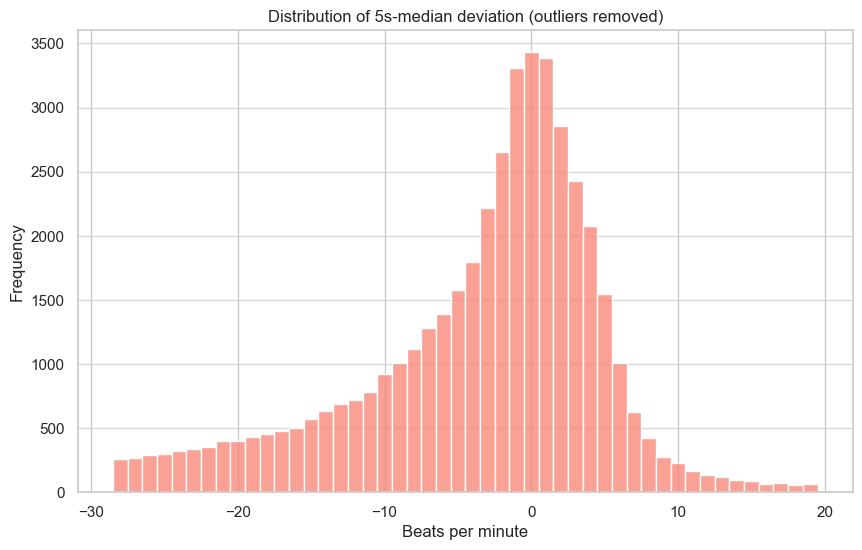

In [296]:
def plot_histogram_without_outliers(df, column_name):
    """
    Plots a histogram of the specified column in the DataFrame, excluding extreme outliers.
    
    Parameters:
    - df: pandas.DataFrame containing the data.
    - column_name: string, the name of the column for which to plot the histogram.
    """
    
    # Step 1: Remove outliers
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    # Step 2: Plot histogram using Seaborn
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(filtered_df[column_name], bins=48, color='salmon', kde=False, ax=ax)
    ax.set(title=f'Distribution of 5s-median deviation (outliers removed)', xlabel='Beats per minute', ylabel='Frequency')
    plt.grid(axis='y', alpha=0.75)
    
    plt.show()

plot_histogram_without_outliers(allx,'delta_med_fmp')

Deviation avenues:
- ! time lag
- by PPT
- by protocol
- by wk, wo 
- by size, gender, race

In [247]:
dftest

,level_0,index,_realtime,value,_time,ppt_id,wk_id,wo_id,datatype,sourcetype,device,myphd_id,_wotime_base,_wotime,_wotime_minutes
0,0,0,2023-06-14 18:55:08,102.0,2023-06-14 18:55:08,18,01,1,hr,WearablePolar,polar,qtz1b19261322566215748,2023-06-14 18:55:08,0.000000,0.000000e+00
1,1,1,2023-06-14 18:55:09,104.0,2023-06-14 18:55:09,18,01,1,hr,WearablePolar,polar,qtz1b19261322566215748,2023-06-14 18:55:08,0.016667,0.000000e+00
2,2,2,2023-06-14 18:55:10,106.0,2023-06-14 18:55:10,18,01,1,hr,WearablePolar,polar,qtz1b19261322566215748,2023-06-14 18:55:08,0.033333,0.000000e+00
3,3,3,2023-06-14 18:55:11,101.0,2029-07-29 18:55:11,18,01,1,hr,WearableFitbit,fitbit,qtz1b19261322566215748,2023-06-14 18:55:08,0.050000,0.000000e+00
4,4,4,2023-06-14 18:55:11,108.0,2023-06-14 18:55:11,18,01,1,hr,WearablePolar,polar,qtz1b19261322566215748,2023-06-14 18:55:08,0.050000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122804,122804,122804,2023-09-03 14:58:17,112.0,2023-09-03 14:58:17,18,12,3,hr,WearablePolar,polar,qtz1b19261322566215748,2023-09-03 14:13:07,45.166667,7.500000e-10
122805,122805,122805,2023-09-03 14:58:18,111.0,2023-09-03 14:58:18,18,12,3,hr,WearablePolar,polar,qtz1b19261322566215748,2023-09-03 14:13:07,45.183333,7.500000e-10
122806,122806,122806,2023-09-03 14:58:19,111.0,2023-09-03 14:58:19,18,12,3,hr,WearablePolar,polar,qtz1b19261322566215748,2023-09-03 14:13:07,45.200000,7.500000e-10
122807,122807,122807,2023-09-03 14:58:20,111.0,2023-09-03 14:58:20,18,12,3,hr,WearablePolar,polar,qtz1b19261322566215748,2023-09-03 14:13:07,45.216667,7.500000e-10


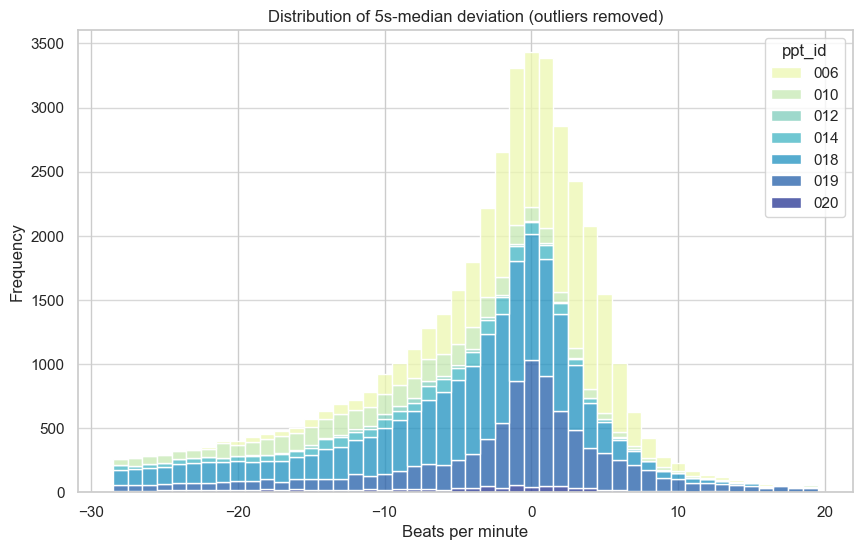

In [354]:
def plot_histogram_colored_by_category(df, column_name, category_column):
    """
    Plots a histogram of the specified value column in the DataFrame,
    colored by the specified category column, excluding extreme outliers.
    
    Parameters:
    - df: pandas.DataFrame containing the data.
    - value_column: string, the name of the column for which to plot the histogram.
    - category_column: string, the name of the categorical column to color the bars.
    """
    
    # Step 1: Remove outliers
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    # Plot histogram with Seaborn
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(data=filtered_df, x=column_name, hue=category_column, bins=48, kde=False, palette='YlGnBu', ax=ax, multiple="stack")
    ax.set(title=f'Distribution of 5s-median deviation (outliers removed)', xlabel='Beats per minute', ylabel='Frequency')
    plt.grid(axis='y', alpha=0.75)
    # plt.legend(title='Participant')
    
    plt.show()

plot_histogram_colored_by_category(allx,'delta_med_fmp','ppt_id')

In [309]:
all_wos = pd.concat(workouts_dfs)
all_wos.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 704913 entries, ('1aIwx8bogLspk1xzG62SxcumhVDDeLu1W', 0) to ('1aVVBKHCPU-dGw3oNGTk7bZihwxDoadBa', 72038)
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   value            704913 non-null  float64       
 1   _realtime        704913 non-null  datetime64[ns]
 2   _time            704913 non-null  datetime64[ns]
 3   ppt_id           704913 non-null  int64         
 4   wk_id            704913 non-null  object        
 5   wo_id            704913 non-null  int64         
 6   datatype         704913 non-null  object        
 7   sourcetype       704913 non-null  object        
 8   device           704913 non-null  object        
 9   myphd_id         704913 non-null  object        
 10  level_0          122809 non-null  float64       
 11  index            122809 non-null  float64       
 12  _wotime_base     122809 non-null  datetime64[ns]
 1

Skipping 1af1bkOOeC7ogNVpHYug0FZkzA0aJroIU as it does not contain 'fitbit_ct'
Skipping 1aNoCaEHuxFedw4OO92xvzUY4ozfL3jSJ as it does not contain 'fitbit_ct'
Skipping 1aVVBKHCPU-dGw3oNGTk7bZihwxDoadBa as it does not contain 'fitbit_ct'


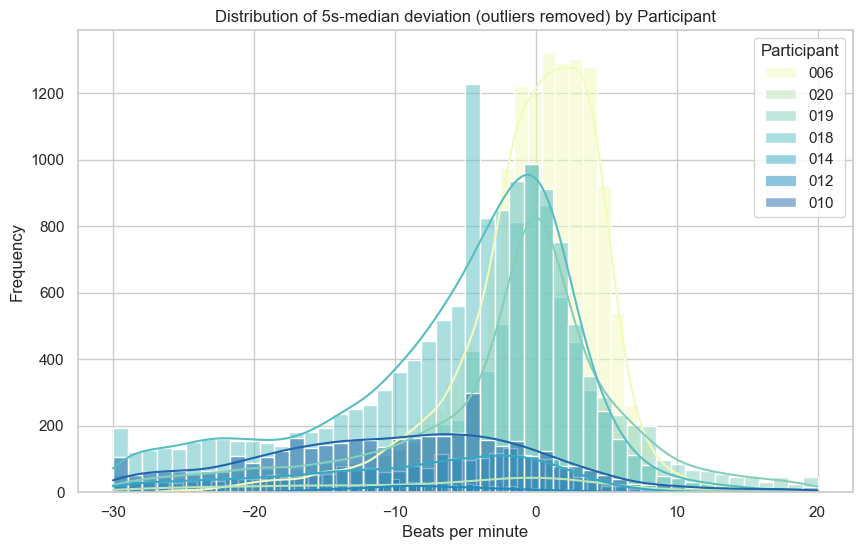

In [355]:
def plot_histogram_loopy(dfs,col_name):
    # manual plot list
    plot_list = ['006','010','012','014','018','019','020']

    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(10, 6))

    # Generate a sequential palette
    palette = sns.color_palette("YlGnBu", len(dfs))

    # Loop through the dictionary and plot each histogram
    for (label, values), color in zip(dfs.items(), palette):
        values = preprocess_5s_v03(values)
        # Check if 'fitbit_ct' column exists
        if 'fitbit_ct' not in values.columns:
            print(f"Skipping {label} as it does not contain 'fitbit_ct'")
            continue
        values['delta_med_fmp'] = np.where(pd.notnull(values['fitbit_ct']), values['fitbit_med'] - values['polar_med'], np.NaN)
        # if values['ppt_id'].iloc[0] not in plot_list:
        #     continue
        filtered_values = values[(values[col_name] >= -30) & (values[col_name] <= 20)]
        sns.histplot(data=filtered_values, x=col_name, kde=True, alpha=0.5, bins=48, label=values['ppt_id'].iloc[0], color=color, ax=ax)

    # Customize the plot
    ax.set_title('Distribution of 5s-median deviation (outliers removed) by Participant')
    ax.set_xlabel('Beats per minute')
    ax.set_ylabel('Frequency')
    plt.legend(title='Participant')  # Show the legend to differentiate between datasets

    plt.show()

plot_histogram_loopy(workouts_dfs,'delta_med_fmp')